In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from anndata import AnnData
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict

In [20]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
plt.rcParams["font.family"] = "DejaVu Sans"

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                 8.0.1
anndata             0.7.6
attr                19.1.0
backcall            0.1.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.14.0
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.3.2
fa2                 NA
fontTools           4.28.5
get_version         2.1
google              NA
h5py                3.1.0
idna                2.8
igraph              0.7.1
ipykernel           5.1.0
ipython_genutils    0.2.0
ipywidgets          7.4.2
jedi                0.13.3
jinja2              2.11.2
joblib              0.14.1
jsonschema          3.0.1
kiwisolver          1.0.1
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.31.0
louvain             0.6.1
lxml                NA
lz4                 3.1.3
markupsafe          1.1.1
matplotlib          3.5.1
more_itertools

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.
running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)


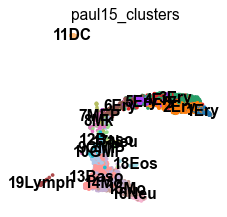

In [7]:
adata = sc.datasets.paul15()
adata.obs.index = [f'cell_{i}' for i in adata.obs.index]
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it
sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989277  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:13)


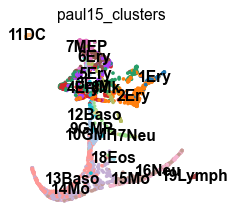

In [8]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


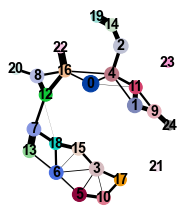

In [9]:
sc.tl.louvain(adata, resolution=1.0)
sc.tl.paga(adata, groups='louvain')
sc.pl.paga(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:13)
--> added 'pos', the PAGA positions (adata.uns['paga'])


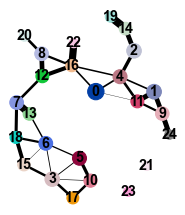

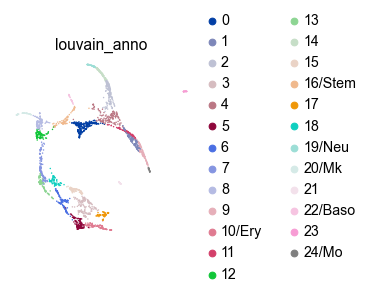

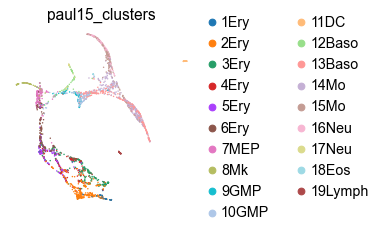

In [10]:
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.paga(adata, threshold=0.03, show=False)
sc.pl.draw_graph(adata, color=['louvain_anno'], s=7)
sc.pl.draw_graph(adata, color=['paul15_clusters'], s=7)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


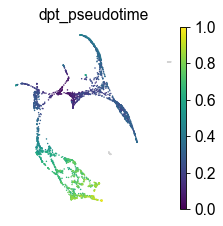

In [11]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]
sc.tl.dpt(adata)
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw
sc.pl.draw_graph(adata, color='dpt_pseudotime', s=7)

In [12]:
import sys 
sys.path.append('../../spatialcorr')
import spatialcorr

In [13]:
import scipy
dist_matrix = scipy.sparse.csgraph.floyd_warshall(
    adata.uns['neighbors']['connectivities'], 
    directed=False, 
    return_predecessors=False, 
    unweighted=False, 
    overwrite=False
)
kernel_matrix = spatialcorr.statistical_test._compute_kernel_matrix(
    adata.obs,
    0.5,
    condition_on_cell_type=False,
    cell_type_key=None,
    dist_matrix=dist_matrix
)
kernel_matrix_cond = spatialcorr.statistical_test._compute_kernel_matrix(
    adata.obs,
    0.5,
    condition_on_cell_type=True,
    cell_type_key='louvain_anno',
    dist_matrix=dist_matrix
)

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
kernel_matrix_cond_small = spatialcorr.statistical_test._compute_kernel_matrix(
    adata.obs,
    0.4,
    condition_on_cell_type=True,
    cell_type_key='louvain_anno',
    dist_matrix=dist_matrix
)

Unconditioned


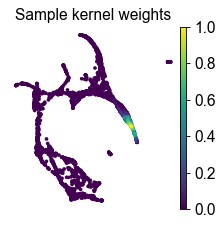

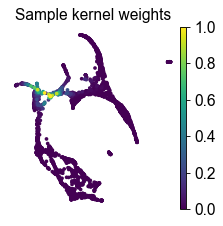

Conditioned


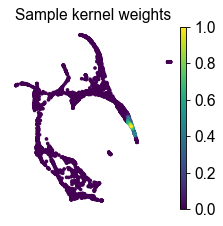

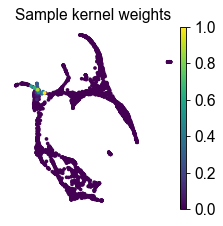

In [15]:
print('Unconditioned')
adata.obs['Sample kernel weights'] = kernel_matrix[100]
sc.pl.draw_graph(adata, color='Sample kernel weights')
adata.obs['Sample kernel weights'] = kernel_matrix[200]
sc.pl.draw_graph(adata, color='Sample kernel weights')

print('Conditioned')
adata.obs['Sample kernel weights'] = kernel_matrix_cond_small[100]
sc.pl.draw_graph(adata, color='Sample kernel weights')
adata.obs['Sample kernel weights'] = kernel_matrix_cond_small[200]
sc.pl.draw_graph(adata, color='Sample kernel weights')

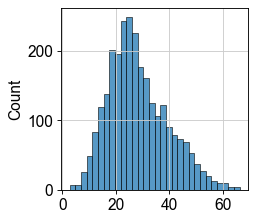

In [16]:
#sns.histplot(np.sum(kernel_matrix_cond, axis=1))
sns.histplot(np.sum(kernel_matrix_cond_small, axis=1))
plt.show()

In [17]:
df_dino = pd.read_csv('Paul15_dino.tsv', sep='\t', index_col=0)
df_dino = df_dino.transpose()
df_dino

,0610007L01Rik,0610009O20Rik,0610010K14Rik,0910001L09Rik,1100001G20Rik,1110002B05Rik,1110004E09Rik,1110007A13Rik,1110007C09Rik,1110013L07Rik,...,hnRNP A2/B1,mFLJ00022,mKIAA0007,mKIAA0569,mKIAA0621,mKIAA1027,mKIAA1575,mKIAA1994,rp9,slc43a2
cell_0,0.100,0.155,0.701,0.254,0.000,0.284,0.316,0.219,0.001,0.004,...,6.971,0.378,0.333,0.766,0.000,2.034,0.158,0.318,4.536,0.000
cell_1,0.119,0.114,0.423,0.660,0.000,0.722,0.553,0.028,0.229,0.182,...,5.606,0.534,1.094,1.176,0.000,0.517,0.206,0.079,1.590,0.109
cell_2,0.457,0.123,1.522,0.345,0.000,0.023,0.802,1.104,0.016,0.000,...,7.879,0.157,1.062,0.786,0.000,1.550,0.273,0.831,1.262,0.141
cell_3,0.378,0.000,1.279,0.343,0.000,1.134,0.557,1.015,0.005,0.198,...,7.346,0.638,1.129,0.000,0.096,2.505,0.089,0.058,1.127,0.023
cell_4,0.047,0.845,2.718,0.426,0.000,0.187,0.874,0.370,0.016,0.287,...,3.903,0.312,1.544,0.012,0.000,2.590,0.672,1.558,1.506,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_2725,0.020,0.011,0.288,0.114,0.000,1.168,1.084,0.338,0.014,0.000,...,8.177,0.127,1.369,0.000,0.000,1.715,0.340,0.005,1.533,0.000
cell_2726,0.064,0.030,4.372,0.985,0.000,1.650,0.172,0.647,0.119,0.000,...,3.856,0.159,0.636,1.151,0.206,3.511,0.005,0.005,1.081,0.000
cell_2727,0.008,0.114,3.067,0.417,0.297,0.001,1.063,0.581,0.164,0.242,...,2.962,0.262,5.049,0.000,0.000,3.602,0.502,0.056,1.614,0.000
cell_2728,1.810,0.019,1.516,2.089,0.000,0.364,0.449,0.194,0.126,0.451,...,7.301,0.719,1.830,0.175,0.009,3.305,0.000,0.019,0.631,0.000


In [18]:
adata_dino = AnnData(df_dino)
adata_dino = adata_dino[adata.obs.index,:]
adata_dino.obs['cluster'] = adata.obs['louvain_anno'] 
adata_dino

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'cluster'

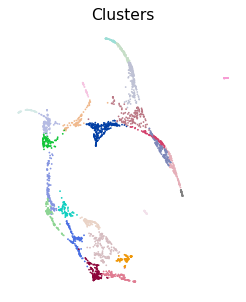

In [21]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(3.3,4)
)
sc.pl.draw_graph(adata, color=['louvain_anno'], s=10, ax=ax, show=False)#, legend_loc='on data', s=6)
ax.get_legend().remove()
ax.set_title('Clusters')
plt.tight_layout()
fig.savefig('./figures/clusters.pdf', format='pdf')
plt.show()

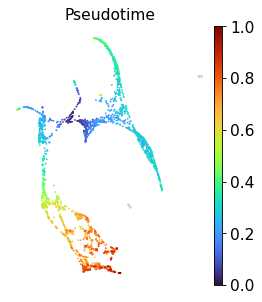

In [22]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(3.5,4)
)
g = sc.pl.draw_graph(adata, color='dpt_pseudotime', s=10, ax=ax, show=False, cmap='turbo')#, legend_loc='on data', s=6)
ax.set_title('Pseudotime')
plt.tight_layout()
fig.savefig('./figures/pseudotime.pdf', format='pdf')
plt.show()

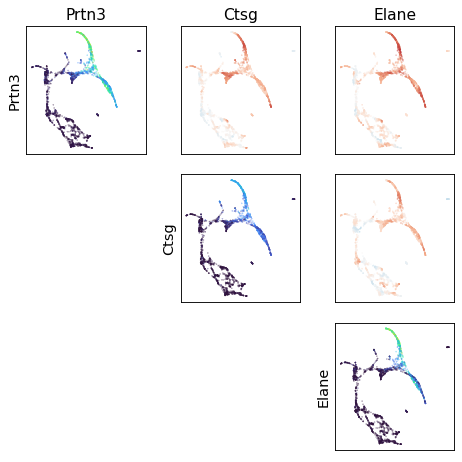

In [27]:
adata_dino.obs['plot_x'] = adata.obsm['X_draw_graph_fa'].T[0]
adata_dino.obs['plot_y'] = -1 * adata.obsm['X_draw_graph_fa'].T[1]
spatialcorr.plot.mult_genes_plot_correlation(
    [
        'Prtn3', 'Ctsg', 'Elane'#, 'Calr'
    ],
    adata_dino,
    'louvain_anno',
    bandwidth=0.4,
    contrib_thresh=10,
    estimate_type='local',
    row_key='plot_y',
    col_key='plot_x',
    dsize=0.04,
    precomputed_kernel=kernel_matrix_cond_small,
    fig_path='./figures/Paul15_pairwise_corr.pdf',
    fig_format='pdf',
    fig_dpi=150
)

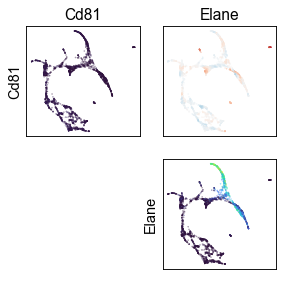

In [104]:
adata_dino.obs['plot_x'] = adata.obsm['X_draw_graph_fa'].T[0]
adata_dino.obs['plot_y'] = -1 * adata.obsm['X_draw_graph_fa'].T[1]
spatialcorr.plot.mult_genes_plot_correlation(
    [
        'Cd81', 'Elane'
    ],
    adata_dino,
    'louvain_anno',
    sigma=0.4,
    contrib_thresh=10,
    estimate_type='local',
    row_key='plot_y',
    col_key='plot_x',
    dsize=0.04,
    kernel_matrix=kernel_matrix_cond_small,
    #fig_path='./figures/pairwise_corr.pdf',
    #fig_format='pdf'
    #fig_dpi=150
)

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


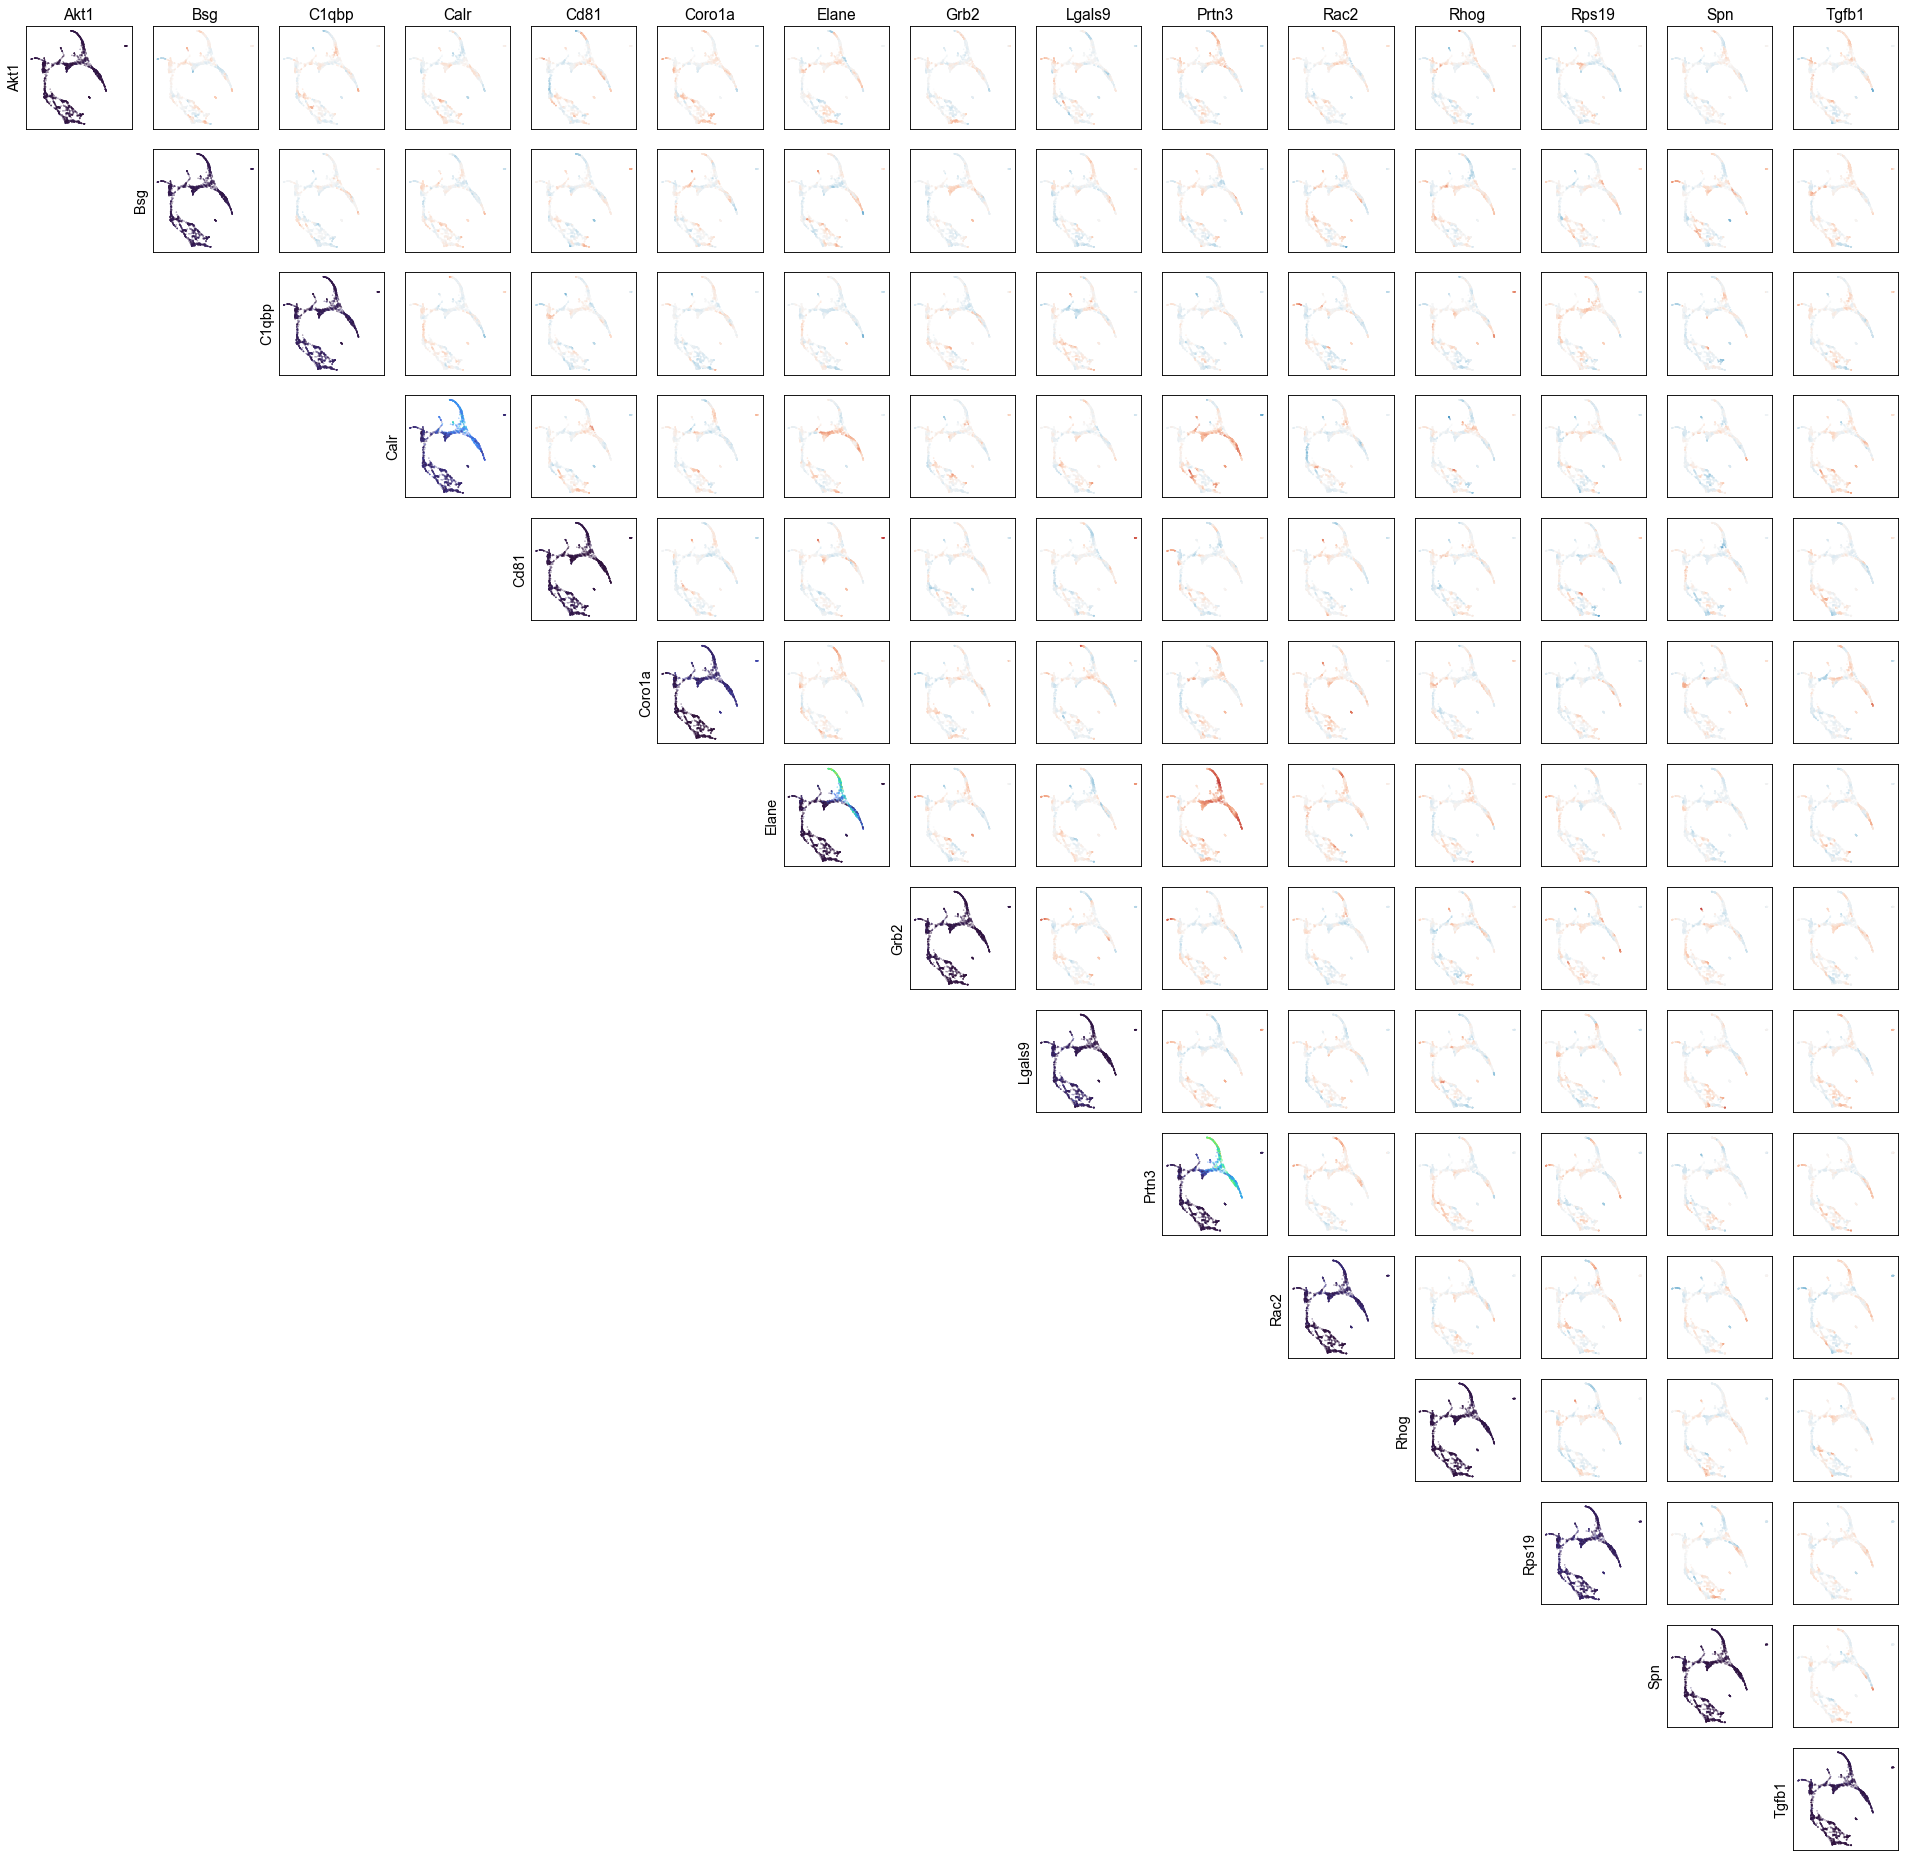

In [110]:
adata_dino.obs['plot_x'] = adata.obsm['X_draw_graph_fa'].T[0]
adata_dino.obs['plot_y'] = -1 * adata.obsm['X_draw_graph_fa'].T[1]
spatialcorr.plot.mult_genes_plot_correlation(
    [
        "Akt1",
        "Bsg",
        "C1qbp",
        "Calr",
        "Cd81",
        "Coro1a",
        "Elane",
        "Grb2",
        "Lgals9",
        "Prtn3",
        "Rac2",
        "Rhog",
        "Rps19",
        "Spn",
        "Tgfb1"
    ],
    adata_dino,
    'louvain_anno',
    sigma=0.4,
    contrib_thresh=10,
    estimate_type='local',
    row_key='plot_y',
    col_key='plot_x',
    dsize=0.04,
    kernel_matrix=kernel_matrix_cond_small,
    #fig_path='./figures/pairwise_corr.pdf',
    #fig_format='pdf'
    #fig_dpi=150
)

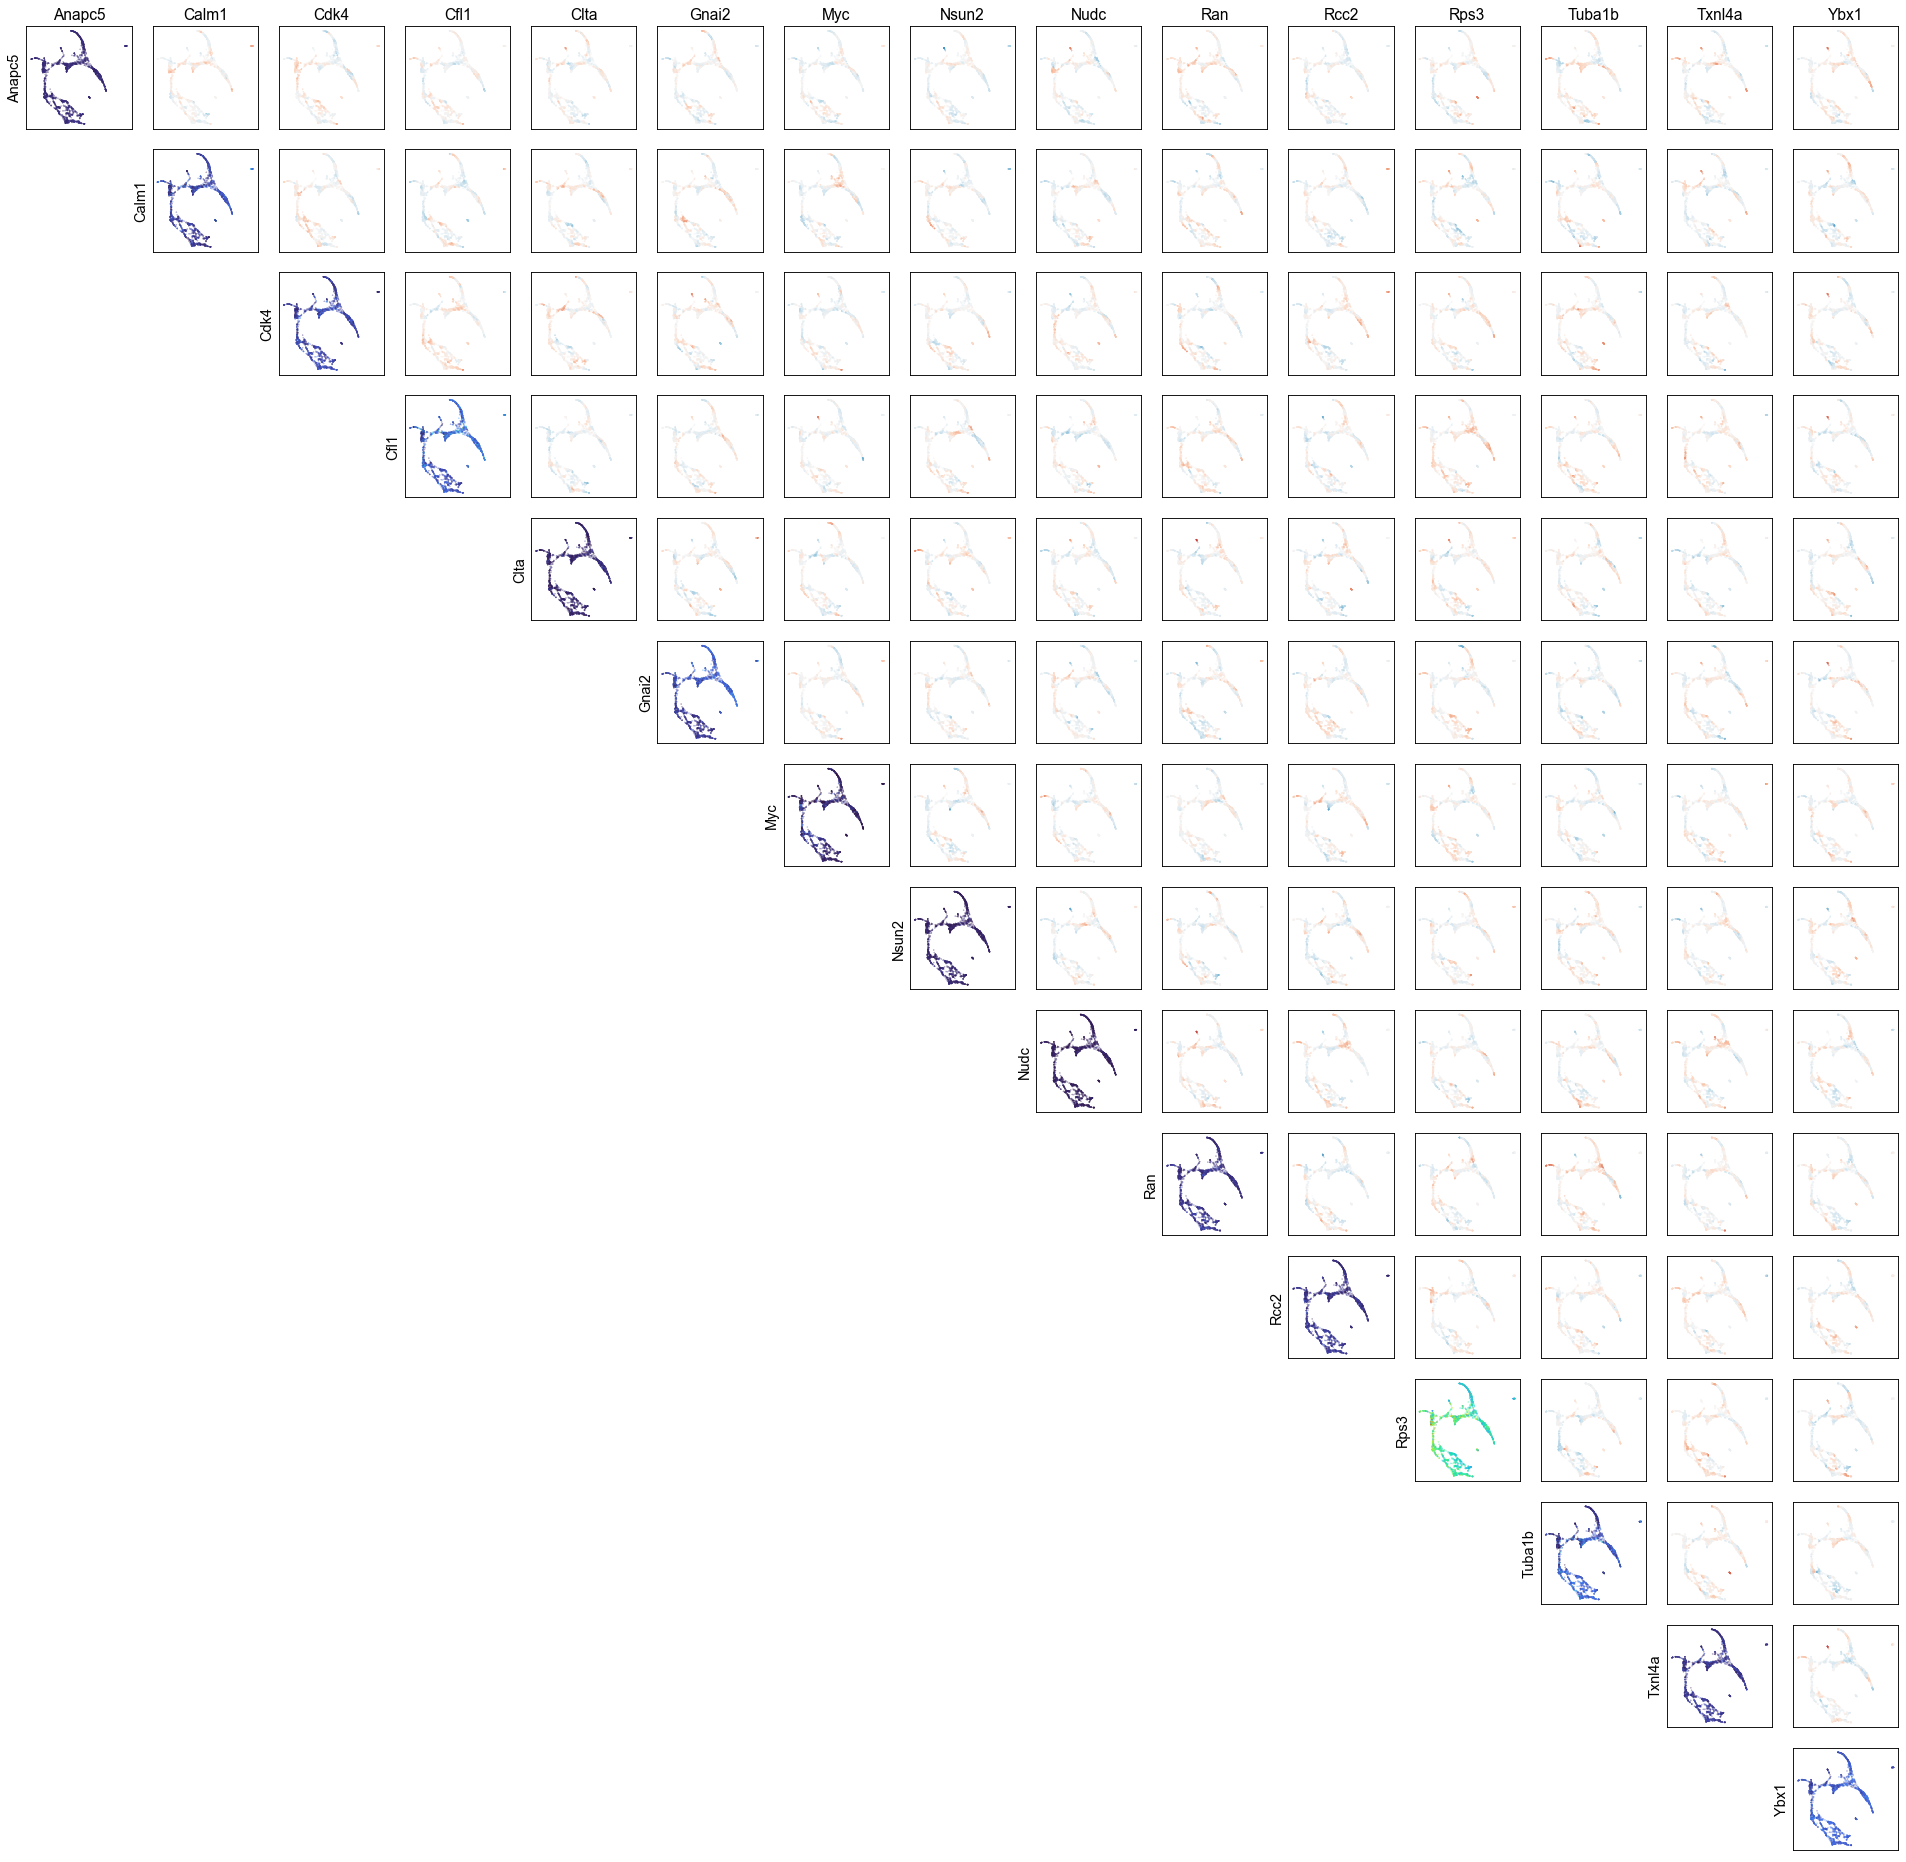

In [83]:
adata_dino.obs['plot_x'] = adata.obsm['X_draw_graph_fa'].T[0]
adata_dino.obs['plot_y'] = -1 * adata.obsm['X_draw_graph_fa'].T[1]
spatialcorr.plot.mult_genes_plot_correlation(
    [
        "Anapc5",
        "Calm1",
        "Cdk4",
        "Cfl1",
        "Clta",
        "Gnai2",
        "Myc",
        "Nsun2",
        "Nudc",
        "Ran",
        "Rcc2",
        "Rps3",
        "Tuba1b",
        "Txnl4a",
        "Ybx1"
    ],
    adata_dino,
    'louvain_anno',
    sigma=0.4,
    contrib_thresh=10,
    estimate_type='local',
    row_key='plot_y',
    col_key='plot_x',
    dsize=0.04,
    kernel_matrix=kernel_matrix_cond_small,
    #fig_path='./figures/pairwise_corr.pdf',
    #fig_format='pdf'
    #fig_dpi=150
)

In [90]:
cell_to_neighs = defaultdict(lambda: [])
for c1_i, (cell_1, dists) in enumerate(zip(adata.obs.index, dist_matrix)):
    for c2_i, (cell_2, dist) in enumerate(zip(adata.obs.index, dists)):
        if c1_i > c2_i:
            continue
        if dist < 0.65:
            cell_to_neighs[cell_1].append(cell_2)
            cell_to_neighs[cell_2].append(cell_1)
            
cell_to_ind = {
    cell: ind
    for ind, cell in enumerate(adata.obs.index)
    
}

ct_to_cells = defaultdict(lambda: [])
#for cell, ct in zip(adata.obs.index, adata.obs['paul15_clusters']):
for cell, ct in zip(adata.obs.index, adata.obs['louvain_anno']):
    ct_to_cells[ct].append(cell)
ct_to_cells.keys()

dict_keys(['8', '1', '17', '2', '4', '15', '13', '18', '10/Ery', '5', '22/Baso', '0', '3', '12', '20/Mk', '14', '6', '11', '21', '16/Stem', '9', '24/Mo', '7', '23', '19/Neu'])

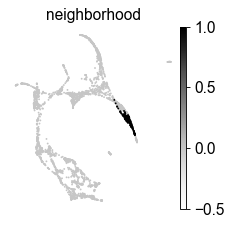

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


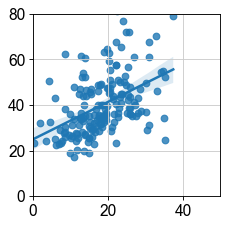

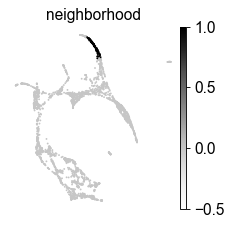

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


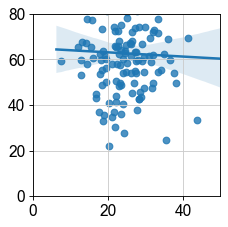

In [114]:
g1, g2 = 'Calr', 'Prtn3'
targ_cell = ct_to_cells['9'][0]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.xlim((0,50))
plt.ylim((0,80))
plt.show()

targ_cell = ct_to_cells['14'][0]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.xlim((0,50))
plt.ylim((0,80))
plt.show()

## JUNK?

In [21]:
p_val, additional = spatialcorr.run_test(
    adata_dino,
    ['Prtn3', 'Calr',],
    0.75,
    run_bhr=False,
    cond_key=None,
    contrib_thresh=10,
    precomputed_kernel=kernel_matrix,
    verbose=1,
    n_procs=1,
    compute_spotwise_pvals=True,
    standardize_var=False,
    max_perms=100,
    mc_pvals=True,
    spot_to_neighbors=None,
    alpha=0.05
)
print('P-value: ', p_val)

Kept 2730/2730 spots.
Hit maximum permutations threshold of 20. P-value = 0.01
P-value:  0.01


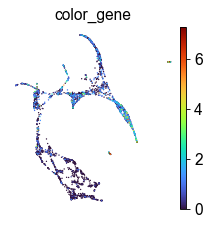

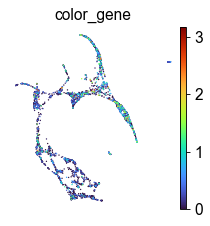

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


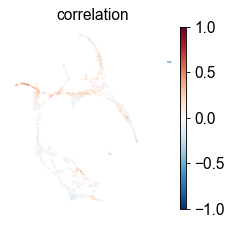

In [22]:
def plot_corr(g1, g2, kern_mat, s=6):
    adata.obs['color_gene'] = adata_dino.obs_vector(g1)
    sc.pl.draw_graph(adata, color='color_gene', cmap='turbo', s=s)
    adata.obs['color_gene'] = adata_dino.obs_vector(g2)
    sc.pl.draw_graph(adata, color='color_gene', cmap='turbo', s=s)
    corrs, keep_inds = spatialcorr.utils.compute_local_correlation(
        adata_dino,
        g1, g2,
        kernel_matrix=kern_mat
    )
    adata_filt = adata[keep_inds,:]
    adata_filt.obs['correlation'] = corrs
    sc.pl.draw_graph(adata_filt, color='correlation', cmap='RdBu_r', vmin=-1, vmax=1, s=s)

plot_corr('Anxa2', 'Ap3s1', kern_mat=kernel_matrix)
#plot_corr('Cpox', 'Klf1')
#plot_corr('Cd74', 'H2-Aa')

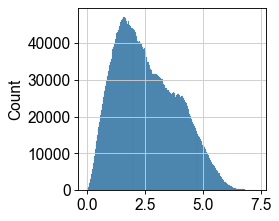

In [23]:
sns.histplot([x for x in dist_matrix.flatten() if x < float('inf')])
plt.show()

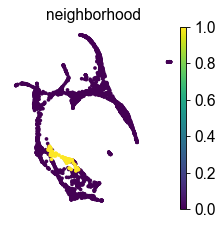

In [26]:
targ_cell = ct_to_cells['15'][0]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='viridis', vmin=0, vmax=1)

In [35]:
adata_counts = sc.datasets.paul15()
df_save_data = pd.DataFrame(
    data=adata_counts.X.astype(int),
    columns=adata_counts.var.index,
    index=[f'cell_{i}' for i in adata_counts.obs.index]
)
df_save_data

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


,0610007L01Rik,0610009O20Rik,0610010K14Rik,0910001L09Rik,1100001G20Rik,1110002B05Rik,1110004E09Rik,1110007A13Rik,1110007C09Rik,1110013L07Rik,...,hnRNP A2/B1,mFLJ00022,mKIAA0007,mKIAA0569,mKIAA0621,mKIAA1027,mKIAA1575,mKIAA1994,rp9,slc43a2
cell_0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2,0
cell_1,0,0,1,1,0,1,1,0,0,0,...,7,1,1,2,0,1,0,0,1,0
cell_2,1,0,3,1,0,0,2,3,0,0,...,17,0,3,2,0,4,1,2,3,0
cell_3,1,0,3,1,0,3,1,2,0,1,...,18,2,2,0,0,6,0,0,2,0
cell_4,0,3,8,1,0,0,2,1,0,0,...,10,1,5,0,0,6,2,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_2725,0,0,1,0,0,4,3,1,0,0,...,19,0,3,0,0,4,1,0,4,0
cell_2726,0,0,8,2,0,3,0,1,0,0,...,8,0,1,2,2,6,0,0,2,0
cell_2727,0,0,1,0,0,0,1,0,0,1,...,1,0,2,0,0,1,0,0,0,0
cell_2728,3,0,3,5,0,1,1,0,0,1,...,12,2,3,0,0,5,0,0,1,0


In [36]:
genes_tf = [
    'Abcb1b', 
    'Acot1', 
    'C3', 
    'Cnpy3', 
    'Dhrs7', 
    'Dtx4', 
    'Edem2', 
    'Etfb', 
    'Ftl1', 
    'Gadd45b', 
    'Herpud1', 
    'Hp', 
    'Il6ra', 
    'Lcn2', 
    'Lcp1', 
    'Lman2', 
    'Lrg1', 
    'Serpinf1', 
    'Snord49b', 
    'Tnfrsf1a', 
    'Tnfsf14', 
    'Trappc1', 
    'Trf', 
    'Xdh'
]

genes_tf_Irf8 = [
    'Abcd1', 
    'Aif1', 
    'BC017643', 
    'Cbl', 
    'Ccdc109b', 
    'Ccl6', 
    'd68', 
    'd74', 
    'dc42se1', 
    'Cdca7', 
    'Csf3r', 
    'Ctss', 
    'Cybb', 
    'Cyp4f18', 
    'Dtx2', 
    'Entpd1', 
    'Ercc6l', 
    'Erp29', 
    'Fastkd3', 
    'Ftl1', 
    'Gda', 
    'Grn', 
    'H2-M3', 
    'Hexa', 
    'Hk3', 
    'Ide', 
    'Il6ra', 
    'Irf5', 
    'Lamp1', 
    'Ly86', 
    'Mtm1', 
    'Napsa', 
    'Ncf1', 
    'Osbpl3', 
    'Pdlim2', 
    'Phgdh', 
    'Pld4', 
    'Psmb10', 
    'Psmb8', 
    'Rgs2', 
    'Rod1', 
    'Snx10', 
    'Spop', 
    'Tapbp', 
    'Tapbpl', 
    'Tm6sf1', 
    'Trem2', 
    'Trem3', 
    'Wipf1', 
    'Xdh', 
    'Zfp296'
]

print(adata_counts.X.shape)

MIN_COUNT = 2

gene_totals = np.sum((np.array(adata_counts.X) > MIN_COUNT).astype(int), axis=0)
gene_totals = gene_totals / adata_counts.X.shape[0]
genes_gt_0_2_spots = [
    gene    
    for gene, total in zip(adata_counts.var.index, gene_totals)
    if total > 0.2
]

print('Total genes meeting threshold: ', len(genes_gt_0_2_spots))

gene_to_total = {
    gene: total
    for gene, total in zip(adata_counts.var.index, gene_totals)
}
print(gene_to_total['Erp29'])
print(set(genes_gt_0_2_spots) & set(genes_tf))
print(set(genes_gt_0_2_spots) & set(genes_tf_Irf8))

print(genes_gt_0_2_spots)

(2730, 3451)
Total genes meeting threshold:  369
0.34908424908424907
{'Lman2', 'Etfb', 'Ftl1'}
{'Ftl1', 'Psmb8', 'Erp29', 'Lamp1'}
['0610010K14Rik', '1500032L24Rik', '2310003F16Rik', '2310028O11Rik', '2700094K13Rik', '2900010J23Rik', '2900073G15Rik', 'AK087942', 'AK158095', 'AK172428', 'AK188353', 'Abcf1', 'Acin1', 'Actb', 'Aes', 'Afmid', 'Ahsa1', 'Ak2', 'Akr1a4', 'Alad', 'Alas1', 'Aldoa', 'Anapc5', 'Ankrd13a', 'Anp32b', 'Anp32e', 'Aprt', 'Aqp1', 'Arhgdia', 'Arhgdib', 'Arpc2', 'Arpc4', 'Atf4', 'Atp5a1', 'Atp5b', 'Atp5c1', 'Atp5d', 'Atp5f1', 'Atp5g3', 'Atp5h', 'Atp5j2', 'Atp5o', 'Atpif1', 'BC033430', 'Bag1', 'Banf1', 'Bat2d', 'Baz1b', 'Blvrb', 'Bola2', 'Brd3', 'Bri3bp', 'Bsg', 'C1qbp', 'Cacybp', 'Cad', 'Calm1', 'Calr', 'Canx', 'Capzb', 'Car1', 'Car2', 'Cbfa2t3', 'Cct3', 'Cct5', 'Cct6a', 'Cct7', 'Cdc37', 'Cdk4', 'Cenp-a', 'Cfl1', 'Chchd2', 'Chd4', 'Clta', 'Cnbp', 'Cope', 'Coro1a', 'Cox4i1', 'Cox5a', 'Cox5b', 'Cox6a1', 'Cox6b1', 'Cox8a', 'Cpox', 'Creg1', 'Csda', 'Csnk2b', 'Cst3', 'Ctbp1',

In [37]:
go_myeloid_dev = [
    'ABI1',    
    'SH2B3',   
    'TSPAN2',  
    'WASF2',   
    'MAEA',    
    'KLF2',    
    'LILRB1',  
    'FAM210B', 
    'SLC9B2',  
    'ZFPM1',   
    'EP300',   
    'EPB42',   
    'DMTN',    
    'EPO', 
    'ERCC2',   
    'EVI2B',   
    'FBN1',    
    'ADGRF5',  
    'FLI1',    
    'JMJD6',   
    'G6PD',    
    'TRIM58',  
    'ZNF385A', 
    'GATA1',   
    'FOXP1',   
    'SIGLEC15',    
    'FLVCR1',  
    'TMOD3',   
    'ANXA2',   
    'ANXA2P2', 
    'HBZ', 
    'NCKAP1L', 
    'APP', 
    'NRROS',   
    'KIT', 
    'LTF', 
    'MEIS1',   
    'RHEX'
]
go_myeloid_dev_lower = [x.lower() for x in go_myeloid_dev]
#    NOTCH2  SLC11A2 PAFAH1B1    CLDN18  ZBTB7A  PIP4K2A ATP6AP1 MED1    FBXW7   SOX6    LYAR    FAM20C  PTPN6   PTPN11  ARID4A  RHAG    BCL6    RPS6    SLC4A1  BPGM    SRC SRF TAL1    THPO    TLR2    TYROBP  LRRK1   MPIG6B  GPR68   ANXA9   L3MBTL3 TNFSF11 PABPC4  PTBP3

In [38]:
def _parse_gene_sets(gene_sets_f):
    gene_set_to_genes = {}
    with open(gene_sets_f, 'r') as f:
        for l in f:
            toks = l.split('\t')
            gene_set = toks[0]
            genes = [x.strip() for x in toks[2:]]
            gene_set_to_genes[gene_set] = genes
    return gene_set_to_genes

gs_to_genes = _parse_gene_sets('./gene_sets/c5.bp.v7.1.symbols.gmt')

In [39]:
gene_lower_to_orig = {
    gene.lower(): gene
    for gene in adata_counts.var.index
}
genes_lower_g2_0_2 = set([y.lower() for y in genes_gt_0_2_spots])

gs_to_genes_meet_thresh = {
    gs: [
        gene_lower_to_orig[x.lower()]
        for x in gs_genes
        if x.lower() in genes_lower_g2_0_2
    ] 
    for (gs, gs_genes) in gs_to_genes.items()
}

In [88]:
print([
    gs
    for gs, genes in gs_to_genes_meet_thresh.items()
    if 'Prtn3' in genes
    #and 'Ctsg' in genes
    and 'Calr' in genes
])

['GO_REGULATION_OF_VESICLE_MEDIATED_TRANSPORT', 'GO_CELL_MOTILITY', 'GO_LEUKOCYTE_MIGRATION', 'GO_LOCOMOTION', 'GO_REGULATION_OF_PHAGOCYTOSIS', 'GO_REGULATION_OF_TRANSPORT', 'GO_PHAGOCYTOSIS', 'GO_POSITIVE_REGULATION_OF_CELL_POPULATION_PROLIFERATION', 'GO_REGULATION_OF_CELL_POPULATION_PROLIFERATION']


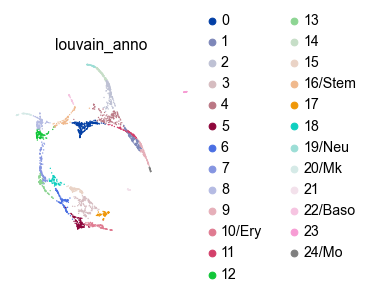

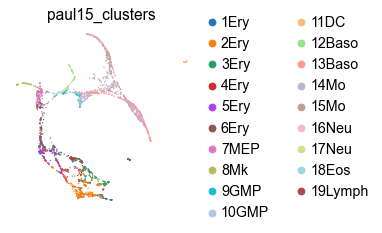

In [349]:
sc.pl.draw_graph(adata, color=['louvain_anno'], s=6)#, legend_loc='on data', s=6)
sc.pl.draw_graph(adata, color=['paul15_clusters'], s=6)#, legend_loc='on data', s=6)

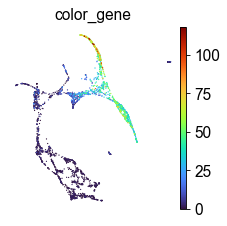

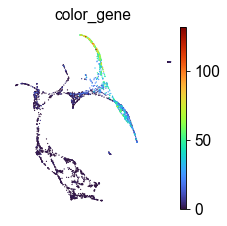

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


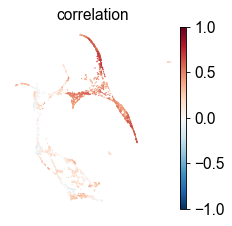

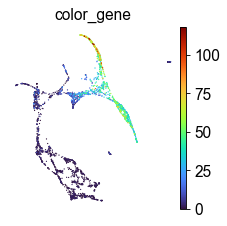

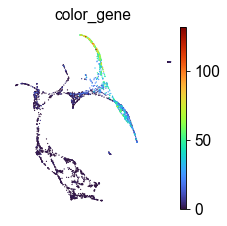

Trying to set attribute `.obs` of view, copying.


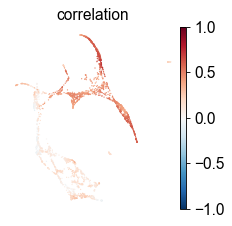

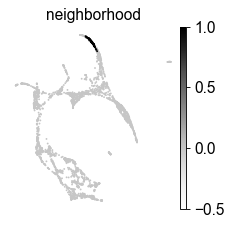

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


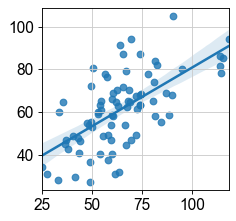

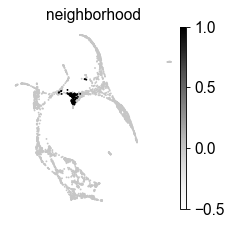

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


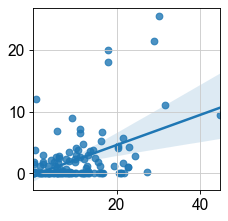

In [53]:
g1, g2 = 'Prtn3', 'Elane'

plot_corr(g1, g2, kern_mat=kernel_matrix_cond, s=5)
plot_corr(g1, g2, kern_mat=kernel_matrix, s=5)

targ_cell = ct_to_cells['14'][3]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.show()

targ_cell = ct_to_cells['0'][3]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.show()

In [535]:
print(gs_to_genes_meet_thresh['GO_MYELOID_CELL_DEVELOPMENT'])
print(gs_to_genes_meet_thresh['GO_MYELOID_LEUKOCYTE_DIFFERENTIATION'])
print(gs_to_genes_meet_thresh['GO_REGULATION_OF_MYELOID_CELL_DIFFERENTIATION'])
print(gs_to_genes_meet_thresh['GO_CELL_DIVISION'])
print(gs_to_genes_meet_thresh['GO_REGULATION_OF_STEM_CELL_DIVISION'])
print(gs_to_genes_meet_thresh['GO_PHAGOCYTOSIS'])
print(gs_to_genes_meet_thresh['GO_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE'])

['Zfpm1', 'Lyar']
['Parp1', 'Zfpm1', 'Acin1', 'Gnas', 'Myc', 'Nme1', 'Nme2', 'Prtn3', 'Cbfa2t3']
['Zfpm1', 'Acin1', 'Gnas', 'Myc', 'Nme1', 'Nme2']
['Cdk4', 'Tuba1b', 'Cfl1', 'Txnl4a', 'Ube2c', 'Clta', 'Gnai2', 'Lig1', 'Myc', 'Ybx1', 'Anapc5', 'Nsun2', 'Rcc2', 'Ran', 'Rps3', 'Top2a', 'Calm1', 'Smc1a', 'Smc3']
[]
['Arpc4', 'Arpc2', 'Lman2', 'Coro1a', 'Elane', 'Hsp90ab1', 'Lyar', 'Prtn3', 'Rac2', 'Actb', 'Sod1', 'Calr', 'Sphk1']
['Npc2', 'Coro1a', 'Pdap1', 'Csnk2b', 'Cst3', 'Ctsd', 'Ctsg', 'Zfpm1', 'Eef2', 'Elane', 'Alad', 'Aldoa', 'Fth1', 'Hspa8', 'Hsp90ab1', 'Hspd1', 'Aprt', 'Lamp1', 'Lgals1', 'Lgals9', 'Mpo', 'Myb', 'Ndufc2', 'Nme2', 'Pnp', 'Pa2g4', 'Prtn3', 'Psmb1', 'Psmc3', 'Psmd1', 'Psmd7', 'Rac2', 'Vamp8', 'Creg1', 'Prdx6', 'Mlec']


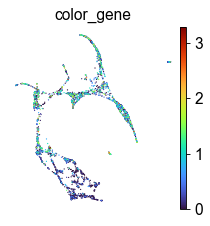

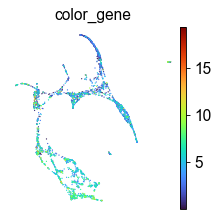

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


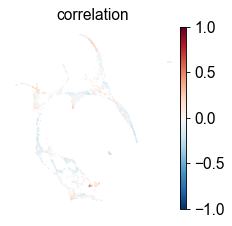

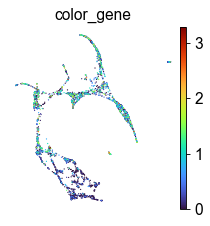

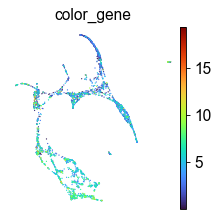

Trying to set attribute `.obs` of view, copying.


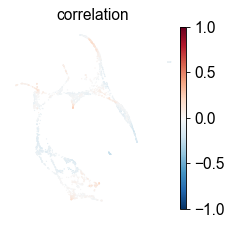

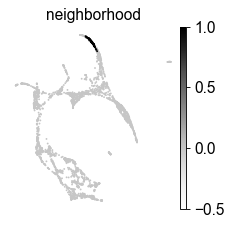

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


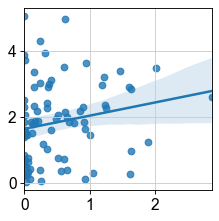

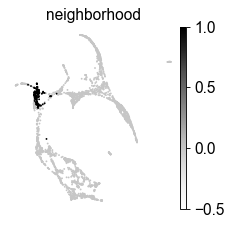

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


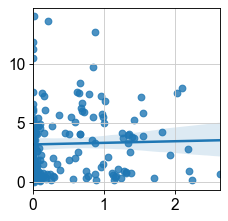

In [48]:
g1, g2 = 'Dock2', 'Sod1'

plot_corr(g1, g2, kern_mat=kernel_matrix_cond, s=5)
plot_corr(g1, g2, kern_mat=kernel_matrix, s=5)

targ_cell = ct_to_cells['14'][3]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.show()

targ_cell = ct_to_cells['8'][3]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.show()

In [ ]:
g1, g2 = 'Actb', 'Prtn3'

plot_corr(g1, g2, s=5)

targ_cell = ct_to_cells['0'][100]
is_neigh = [int(x in cell_to_neighs[targ_cell]) for x in adata.obs.index]
adata.obs['neighborhood'] = is_neigh
sc.pl.draw_graph(adata, color='neighborhood', cmap='Greys', legend_loc=None, vmin=-0.5, vmax=1, s=11)

sns.regplot(
    adata_dino.obs_vector(g1)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]],
    adata_dino.obs_vector(g2)[[cell_to_ind[x] for x in cell_to_neighs[targ_cell]]]
)
plt.show()



In [98]:
g1, g2 = 'Actb', 'Prtn3'
p_val, additional = spatialcorr.run_test(
    adata_dino,
    [g1, g2],
    0.75,
    run_bhr=False,
    cond_key=None,
    contrib_thresh=10,
    precomputed_kernel=kernel_matrix_cond_small,
    verbose=1,
    n_procs=1,
    compute_spotwise_pvals=True,
    standardize_var=False,
    max_perms=100,
    mc_pvals=True,
    spot_to_neighbors=None,
    alpha=0.05
)
print('P-value: ', p_val)

Kept 2132/2730 spots.
Hit maximum permutations threshold of 20. P-value = 0.01


IndexError: index 2132 is out of bounds for axis 0 with size 2132

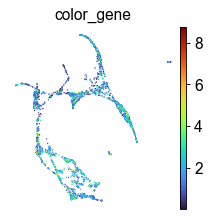

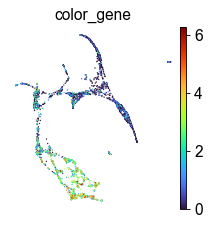

Trying to set attribute `.obs` of view, copying.


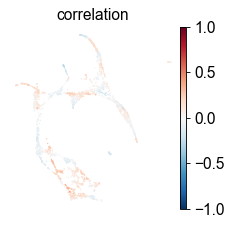

Kept 2722/2730 spots.
Hit maximum permutations threshold of 20. P-value = 0.13
P-value (Conditioned):  0.13
Kept 2730/2730 spots.
Hit maximum permutations threshold of 20. P-value = 0.01
P-value (Unconditioned):  0.01


In [64]:
g1, g2 = 'Lyar', 'Sphk1'
plot_corr(g1, g2, kern_mat=kernel_matrix_cond)
p_val, additional = spatialcorr.run_test(
    adata_dino,
    [g1, g2],
    0.75,
    run_bhr=False,
    cond_key='cluster',
    contrib_thresh=10,
    precomputed_kernel=kernel_matrix_cond,
    verbose=1,
    n_procs=1,
    compute_spotwise_pvals=True,
    standardize_var=False,
    max_perms=100,
    mc_pvals=True,
    spot_to_neighbors=None,
    alpha=0.05
)
print('P-value (Conditioned): ', p_val)

p_val, additional = spatialcorr.run_test(
    adata_dino,
    [g1, g2],
    0.75,
    run_bhr=False,
    cond_key=None,
    contrib_thresh=10,
    precomputed_kernel=kernel_matrix,
    verbose=1,
    n_procs=1,
    compute_spotwise_pvals=True,
    standardize_var=False,
    max_perms=100,
    mc_pvals=True,
    spot_to_neighbors=None,
    alpha=0.05
)
print('P-value (Unconditioned): ', p_val)



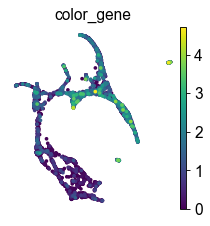

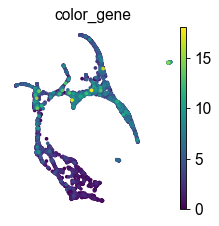

Trying to set attribute `.obs` of view, copying.


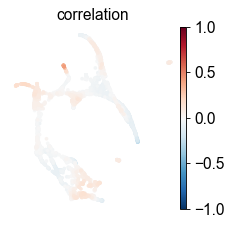

In [273]:
plot_corr('Lcp1', 'Psmb8')

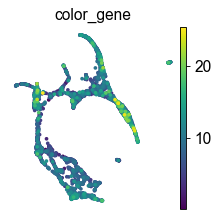

In [229]:
adata.obs['color_gene'] = adata_dino.obs_vector('Ftl1')
sc.pl.draw_graph(adata, color='color_gene')

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


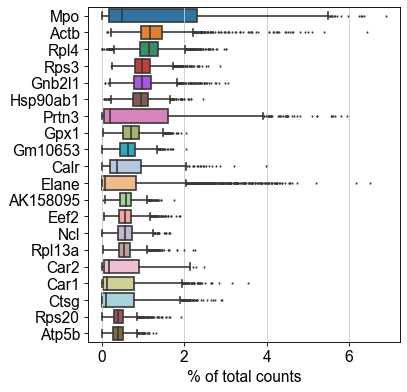

In [109]:
sc.pl.highest_expr_genes(adata_dino, n_top=20, )

In [92]:
df_save_data.transpose().to_csv('Paul15_counts.tsv', sep='\t')

In [596]:
df_dist_matrix = pd.DataFrame(
    data=dist_matrix,
    index=adata.obs.index,
    columns=adata.obs.index
)
df_dist_matrix.to_csv('Paul15_dist_matrix.tsv', sep='\t')

In [65]:
adata_dino.obs

,cluster
cell_0,8
cell_1,1
cell_2,17
cell_3,2
cell_4,17
...,...
cell_2725,6
cell_2726,24/Mo
cell_2727,8
cell_2728,2


In [66]:
adata_dino.obs.to_csv('Paul15_meta.tsv', sep='\t')